# Deep Neural Network Evaluation Report

This notebook evaluates deep neural network models based on their performance metrics.
It visualizes key patterns and provides guidance on model comparison and selection.

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from matplotlib.colors import LogNorm
from os.path import join
import ast

# Load your dataset
df = pd.read_csv(join("data", "DNN_trained_models_docs.csv"))

# Filter to only include models from a certain data_file
data_file = "2D_002.csv"
df = df[df["data_file"] == data_file]

# Add readable column names
df = df.reset_index(drop=True)
df["model_id"] = df.index.map(lambda i: f"Model_{i:03d}")



## Normalize Metrics and Compute Composite Score

We normalize all key performance metrics so they range from 0 (best) to 1 (worst), then average them into a composite score.
This allows us to compare models holistically using multiple criteria.

**Metrics used:**
- MAE, RMSE, MAPE, Median AE, Inference Time, Validation Loss

**Lower scores are better.**

In [44]:
metrics = ["mae", "rmse", "val_loss_best", "mape", "median_ae", "inference_time_ms"]
scaler = MinMaxScaler()
df_norm = df.copy()
df_norm[[f"{m}_norm" for m in metrics]] = scaler.fit_transform(df[metrics])
df["composite_score"] = df_norm[[f"{m}_norm" for m in metrics]].mean(axis=1)

# Sort models by performance
df_sorted = df.sort_values(by="composite_score")
df_sorted[["model_id", "composite_score"] + metrics].head(10)

,model_id,composite_score,mae,rmse,val_loss_best,mape,median_ae,inference_time_ms
98,Model_098,0.034308,0.021237,0.076909,0.020685,140.305649,0.000895,0.041305
21,Model_021,0.041390,0.019389,0.071470,0.018880,294.623266,0.001119,0.049695
53,Model_053,0.042580,0.034060,0.082018,0.002949,9420.835896,0.014420,0.032025
49,Model_049,0.046508,0.030257,0.111862,0.028327,834.911728,0.003783,0.033172
37,Model_037,0.051116,0.034872,0.090700,0.007265,7124.950051,0.013249,0.037514
55,Model_055,0.052299,0.019616,0.075012,0.018803,1050.839326,0.001574,0.056693
92,Model_092,0.054266,0.021027,0.069967,0.004092,3708.111295,0.005412,0.060591
42,Model_042,0.054932,0.027700,0.075287,0.004737,3412.981254,0.012159,0.052714
88,Model_088,0.055592,0.018431,0.071741,0.017994,311.516524,0.001621,0.061693
47,Model_047,0.055617,0.040742,0.094169,0.007424,9520.815759,0.023620,0.029019


## Validation Loss vs. MAE

This scatter plot compares **validation loss** to **mean absolute error**.

**Interpretation:**
- Ideally, we want both values to be low.
- Models in the **bottom-left** quadrant are best: low validation loss *and* low MAE.
- Points drifting rightward or upward suggest either overfitting or underfitting.

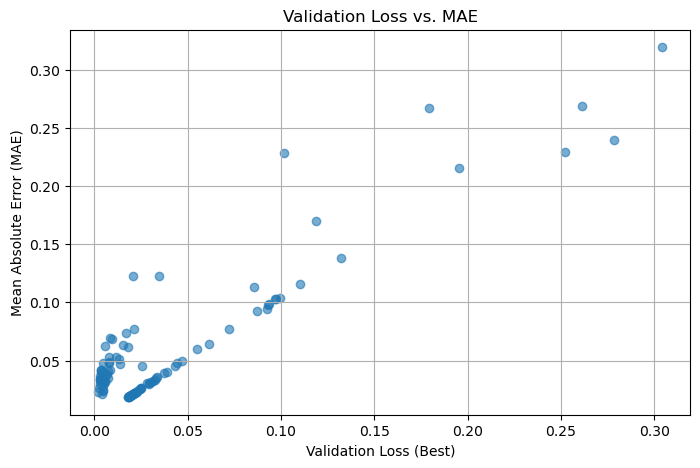

In [45]:
plt.figure(figsize=(8, 5))
plt.scatter(df["val_loss_best"], df["mae"], alpha=0.6)
plt.xlabel("Validation Loss (Best)")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Validation Loss vs. MAE")
plt.grid(True)
plt.show()

## Total Layer Size vs. MAE

Here, we analyze the total number of neurons across all layers vs. MAE.

**Interpretation:**
- This helps identify if larger models actually perform better.
- If there's no clear trend, adding more layers/neurons may not improve accuracy.
- Beware of overfitting in very large models.

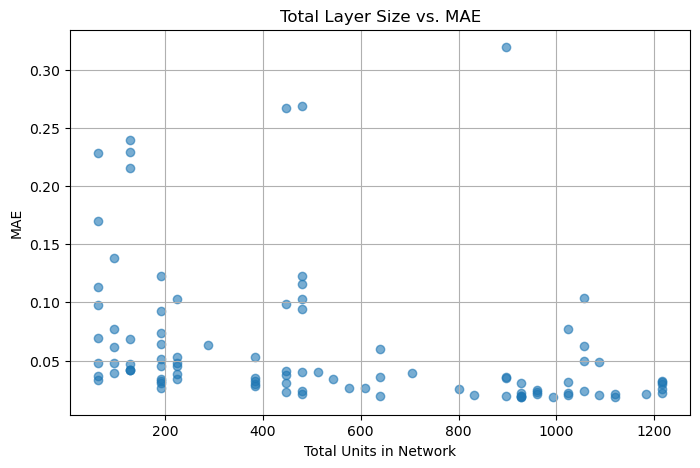

In [46]:
df["layer_sizes_list"] = df["layer_sizes"].apply(ast.literal_eval)
df["total_units"] = df["layer_sizes_list"].apply(sum)

plt.figure(figsize=(8, 5))
plt.scatter(df["total_units"], df["mae"], alpha=0.6)
plt.xlabel("Total Units in Network")
plt.ylabel("MAE")
plt.title("Total Layer Size vs. MAE")
plt.grid(True)
plt.show()

## Dropout Rate vs. Composite Score

Regularization is key to generalization. This plot shows how dropout rate affects overall model quality.

**Interpretation:**
- Look for a **U-shaped curve**: too little or too much dropout can hurt.
- Mid-range dropout (e.g. 0.2–0.5) often leads to better generalization.

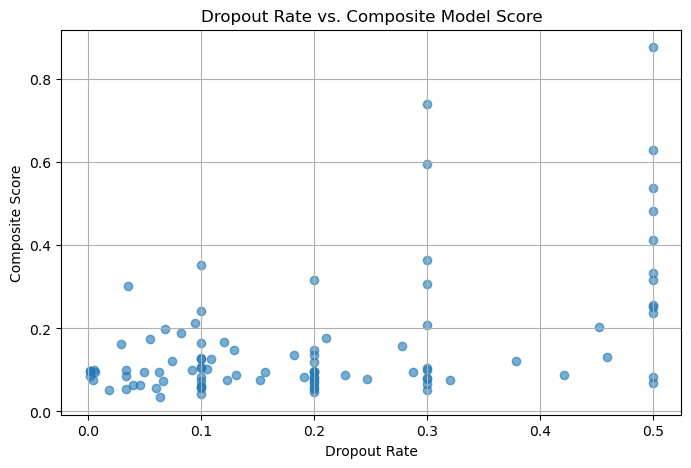

In [47]:
plt.figure(figsize=(8, 5))
plt.scatter(df["dropout_rate"], df["composite_score"], alpha=0.6)
plt.xlabel("Dropout Rate")
plt.ylabel("Composite Score")
plt.title("Dropout Rate vs. Composite Model Score")
plt.grid(True)
plt.show()

## Epochs vs. Validation Loss

This shows when models hit their best validation performance.

**Interpretation:**
- Models that converge early (low `best_epoch`) are often better regularized.
- Very high epoch counts with no improvement suggest overtraining.

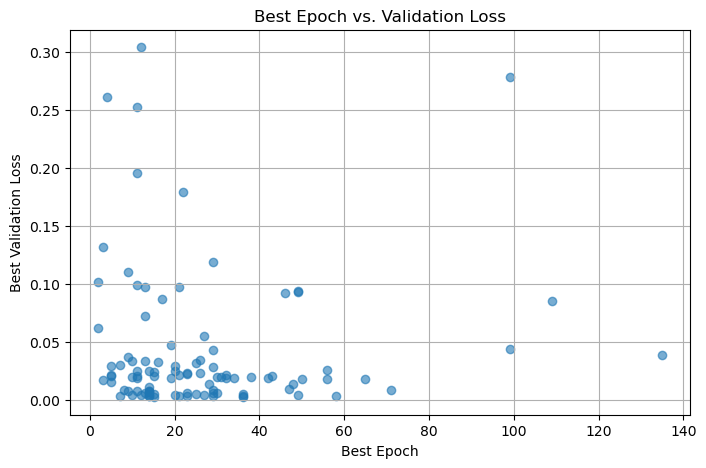

In [48]:
plt.figure(figsize=(8, 5))
plt.scatter(df["best_epoch"], df["val_loss_best"], alpha=0.6)
plt.xlabel("Best Epoch")
plt.ylabel("Best Validation Loss")
plt.title("Best Epoch vs. Validation Loss")
plt.grid(True)
plt.show()

## Top 10 Models (Composite Score)

Below is a summary table of the 10 best-performing models using the composite score.

In [49]:
top_n = 10
cols_to_show = [
    "model_id", "mae", "rmse", "r2", "val_loss_best", 
    "composite_score", "best_epoch", "dropout_rate", "optimizer"
]
df_sorted[cols_to_show].head(top_n)

,model_id,mae,rmse,r2,val_loss_best,composite_score,best_epoch,dropout_rate,optimizer
98,Model_098,0.021237,0.076909,0.996629,0.020685,0.034308,15,0.063050,Adam
21,Model_021,0.019389,0.071470,0.997089,0.018880,0.041390,11,NaN,Adamax
53,Model_053,0.034060,0.082018,0.996166,0.002949,0.042580,14,0.100000,Nadam
49,Model_049,0.030257,0.111862,0.992868,0.028327,0.046508,29,0.200000,Adam
37,Model_037,0.034872,0.090700,0.995311,0.007265,0.051116,14,0.300000,Adam
55,Model_055,0.019616,0.075012,0.996793,0.018803,0.052299,19,0.018249,Adam
92,Model_092,0.021027,0.069967,0.997210,0.004092,0.054266,27,0.033576,Adam
42,Model_042,0.027700,0.075287,0.996770,0.004737,0.054932,25,0.200000,Adam
88,Model_088,0.018431,0.071741,0.997067,0.017994,0.055592,65,0.060294,Adam
47,Model_047,0.040742,0.094169,0.994946,0.007424,0.055617,11,0.100000,Adamax


## Performance by Optimizer

This shows how different optimizers impact MAE using a violin plot.

**Interpretation:**
- Look at both the spread (variance) and median.
- Narrow, low-centered violins indicate consistently strong performance.

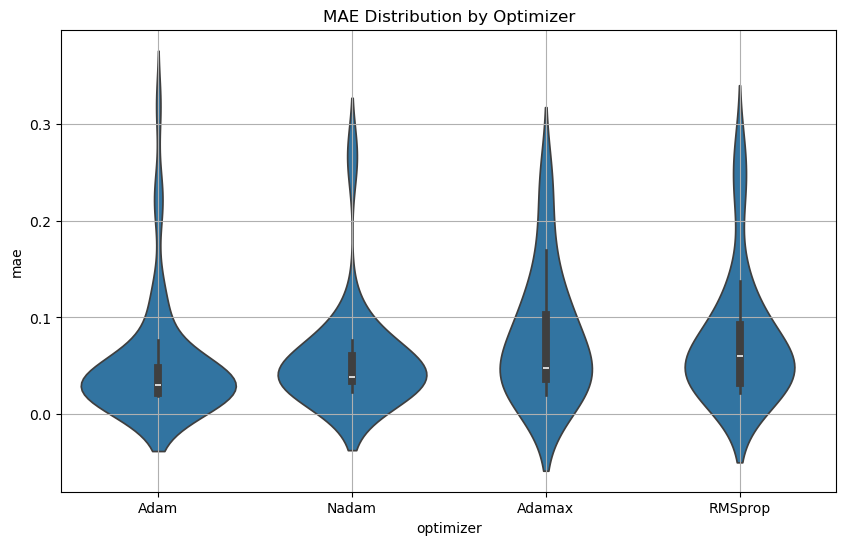

In [50]:
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x="optimizer", y="mae")
plt.title("MAE Distribution by Optimizer")
plt.grid(True)
plt.show()

## Box Plot by Activation Function

Shows how activation function affects the validation loss.

**Interpretation:**
- Compare medians (horizontal line) and spread (IQR).
- Identify which activations yield more stable models.

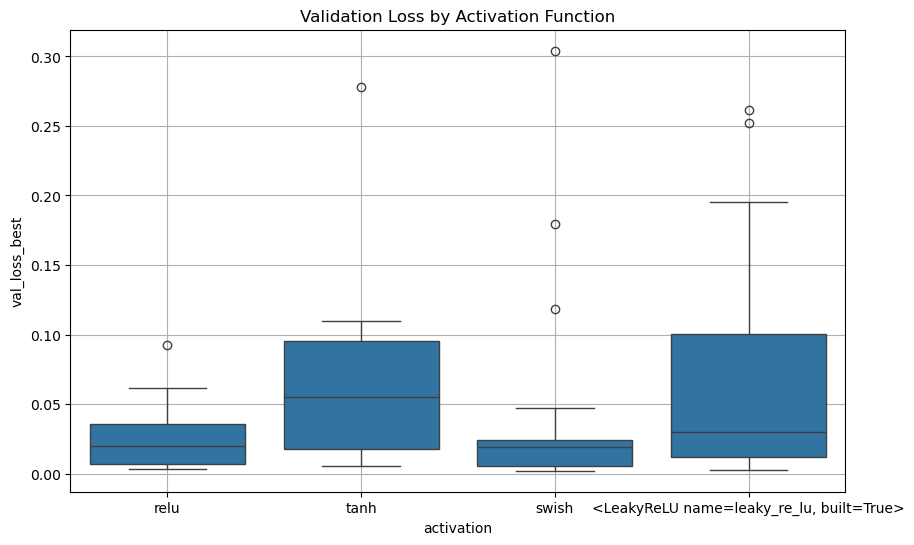

In [51]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="activation", y="val_loss_best")
plt.title("Validation Loss by Activation Function")
plt.grid(True)
plt.show()

## Heatmap of Layer Sizes

This visualizes how architectures vary. Each row is a model, each column a layer.

**Interpretation:**
- Brighter = more units in that layer.
- Patterns reveal architectural clusters or trends.

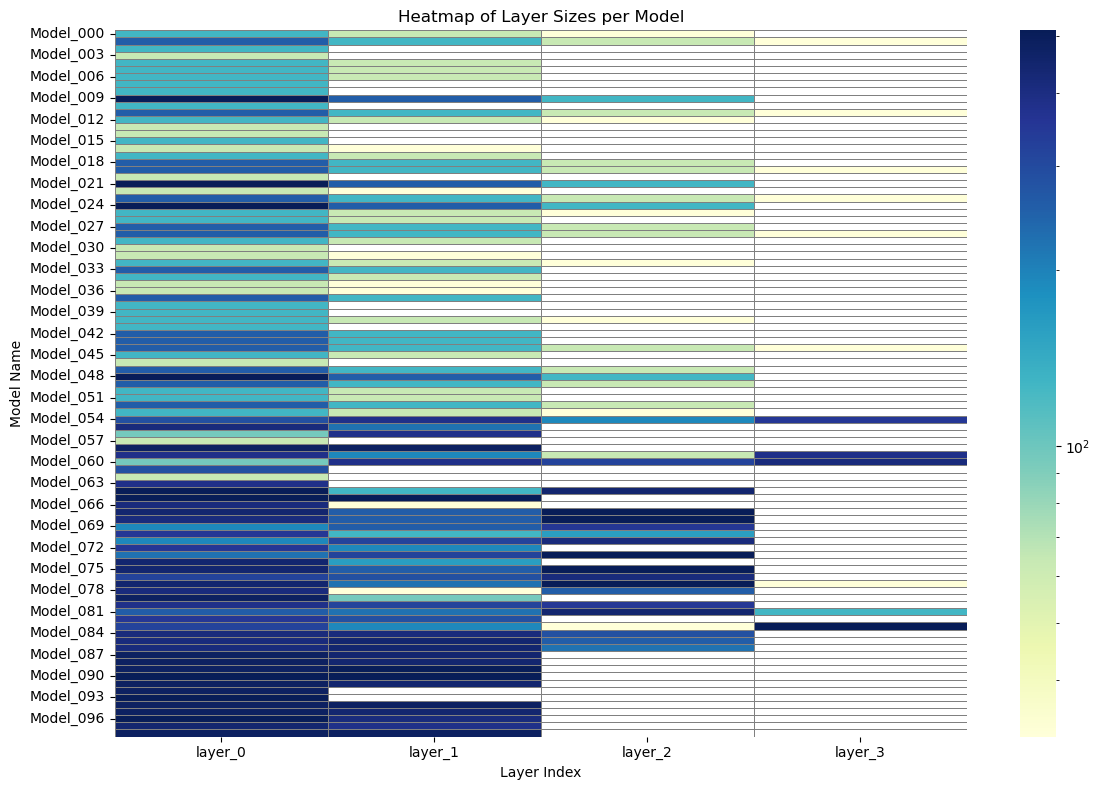

In [52]:
max_layers = df["layer_sizes_list"].apply(len).max()
layer_df = pd.DataFrame(df["layer_sizes_list"].to_list(), columns=[f"layer_{i}" for i in range(max_layers)])
layer_df = layer_df.fillna(0)
layer_df.index = df["model_id"]

plt.figure(figsize=(12, 8))
sns.heatmap(layer_df, cmap="YlGnBu", cbar=True, linewidths=0.5, linecolor='grey', norm=LogNorm())
plt.title("Heatmap of Layer Sizes per Model")
plt.xlabel("Layer Index")
plt.ylabel("Model Name")
plt.tight_layout()
plt.show()